# Part 1: Transformers

## Task 1

The CNN/Daily Mail dataset is a large collection of news articles paired with human-written summaries, commonly used for tasks in abstractive text summarization. The dataset consists of articles from CNN and the Daily Mail, covering a broad range of topics such as politics, science, technology, and health. Each example in the dataset includes two main components: the article, which is a full-length news piece, and the summary, which is a concise, human-written version of the article, typically consisting of a few sentences.

The dataset is split into three subsets: a training set with over 280,000 examples, a validation set with around 13,000 examples, and a test set containing about 11,000 examples. These splits allow for the training, validation, and evaluation of summarization models. The primary use of this dataset is to train and evaluate models that perform abstractive summarization, where the model generates summaries that capture the key points of an article in a condensed form, rather than extracting exact phrases.

This dataset is widely used in the field of natural language processing (NLP) for developing and benchmarking summarization models. It is particularly valuable because it challenges models to understand the content of an article and produce coherent, human-like summaries. The CNN/Daily Mail dataset is considered one of the most popular and standard datasets for summarization tasks, making it an excellent choice for model development and comparison.

In [ ]:
!pip install transformers==4.30.0 datasets==2.14.0 evaluate==0.3.0 rouge-score==0.0.4 nltk==3.8.1

In [ ]:
!pip install --upgrade --force-reinstall numpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 114.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.
diffusers 0.32.2 requires huggingface-hub>=0.23.2, but you have huggingface-hub 0.20.3 which is incompatible.
accelerate 1.5.2 requires huggingface-hub>=0.21.0, but you have huggingface-hub 0.20.3 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
peft 0.14.0 requires huggingface-hub>=0.25.0, but you have huggingface-hub 0.20.3 which is incompatible.


In [ ]:
import evaluate
import numpy as np
from datasets import load_dataset

from transformers import (
    BartTokenizer,
    BartForConditionalGeneration,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments
)

dataset = load_dataset('cnn_dailymail', '3.0.0')

# For demonstration, take a smaller subset (e.g., 2000 samples) from 'train'
small_train_dataset = dataset['train'].shuffle(seed=42).select(range(2000))

def remove_invalid_rows(example):
    """
    Returns False if 'article' or 'highlights' is None or empty.
    Otherwise returns True.
    """
    art = example.get("article", None)
    summ = example.get("highlights", None)
    if art is None or summ is None:
        return False
    if art.strip() == "" or summ.strip() == "":
        return False
    return True

def debug_print_samples(data, n=3):
    """
    Prints 'article' and 'highlights' from the first n samples
    to confirm everything is valid.
    """
    for i in range(n):
        print(f"Sample {i}:")
        print("Article:", data[i]["article"])
        print("Highlights:", data[i]["highlights"])
        print("-----")

cleaned_data = small_train_dataset.filter(remove_invalid_rows)
print(f"Cleaned subset size: {len(cleaned_data)}")

debug_print_samples(cleaned_data, n=2)

dataset_split = cleaned_data.train_test_split(test_size=0.1, seed=42)
train_data = dataset_split['train']
test_data = dataset_split['test']

print(f"Train size: {len(train_data)}")
print(f"Test size:  {len(test_data)}")

model_name = "facebook/bart-large-cnn"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

def preprocess_data(examples):
    # Tokenize articles
    inputs = tokenizer(
        examples["article"],
        max_length=1024,
        truncation=True,
        padding="max_length"
    )
    # Tokenize summaries
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples["highlights"],
            max_length=150,
            truncation=True,
            padding="max_length"
        )["input_ids"]

    inputs["labels"] = labels
    return inputs

train_data = train_data.map(preprocess_data, batched=True)
test_data = test_data.map(preprocess_data, batched=True)

# Convert to torch format
train_data.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_data.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=2,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="epoch",
    predict_with_generate=True,   # Important for seq2seq tasks
    generation_max_length=150,
    generation_num_beams=4,
    report_to="none",            # Disable Weights & Biases logging
)

bleu_metric = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # predictions are token IDs from model.generate
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # ROUGE (string-based)
    rouge_scores = rouge_metric.compute(
        predictions=decoded_preds,
        references=decoded_labels
    )

    # BLEU (token-based)
    pred_tokens = [pred.split() for pred in decoded_preds]  # shape: (N, tokens)
    ref_tokens  = [ref.split() for ref in decoded_labels]   # shape: (N, tokens)

    bleu_scores = bleu_metric.compute(
        predictions=pred_tokens,
        references=ref_tokens
    )

    return {
        "bleu":   round(bleu_scores["bleu"], 4),
        "rouge1": round(rouge_scores["rouge1"].mid.fmeasure, 4),
        "rouge2": round(rouge_scores["rouge2"].mid.fmeasure, 4),
        "rougeL": round(rouge_scores["rougeL"].mid.fmeasure, 4),
    }

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

eval_results = trainer.evaluate()
print("\nEvaluation Results:")
print(eval_results)


AttributeError: module 'numpy' has no attribute 'dtypes'

I was unable to complete Task 1 due to recurring dependency conflicts that I was unable to resolve in google colab. Even after researching compatible package versions, I was still getting conflicts. I believe the issue must be with underlying packages that I have not upgraded/downgraded. I ran out of time before I was able to fix this issue.

# Part 2

## Task 2

A practical real-world application that can be formulated as a Markov Decision Process (MDP) is autonomous driving. In this setting, the state space includes the vehicle's current position, velocity, acceleration, proximity to other vehicles and pedestrians, road conditions (such as wet or dry surfaces), traffic signals, road signs, and sensor readings from LiDAR and cameras. The action space comprises decisions like accelerating, braking, steering (left or right), changing lanes, or stopping at intersections. The transition model qualitatively describes how actions influence states; for example, accelerating generally increases the vehicle’s speed and changes its position, but external factors such as other drivers' behaviors, pedestrians, or environmental conditions introduce uncertainty. Finally, the reward function qualitatively reflects driving objectives by assigning positive rewards for safely and efficiently reaching destinations, while penalizing undesirable outcomes such as collisions, unsafe driving behaviors, traffic violations, or inefficient routes. This MDP formulation enables reinforcement learning algorithms to develop policies that effectively balance safety, efficiency, and comfort in autonomous driving.

## Task 3

Reinforcement learning (RL) can effectively solve the problem of personalized recommendation in recommender systems. Traditional recommender systems typically utilize static methods, like collaborative filtering or content-based filtering, which often fail to adapt dynamically to changing user preferences or behaviors over time. Reinforcement learning offers a powerful solution by modeling recommendations as a sequential decision-making problem, allowing the system to dynamically interact with users and continuously refine recommendations based on user feedback. This approach can greatly enhance user satisfaction and engagement.

One prominent open-source project addressing this problem is RecSim, developed by Google Research. RecSim is a configurable platform designed specifically for simulating sequential user interactions and training reinforcement learning-based recommender systems. It enables researchers and developers to create detailed simulations of user behavior, test different RL algorithms, and systematically evaluate recommendation policies in a controlled environment.

In detail, RecSim provides customizable components that include simulated users (agents with specific tastes, attention spans, and behavioral patterns), recommendation policies (algorithms determining the next item to suggest), and user-choice models (how users respond to the recommendations). This modularity lets users easily experiment with new RL techniques, investigate complex user-item dynamics, and optimize recommendation policies. By leveraging RecSim, developers and researchers can build and test more adaptive and effective recommendation systems, capable of learning and responding to evolving user preferences over time.

## Task 4

In [ ]:
'''
Q-Learning: Watkins, C. J. C. H., & Dayan, P. (1992). Q-learning. Machine learning, 8(3–4), 279–292.
Reinforcement Learning: Sutton, R. S., & Barto, A. G. (2018). Reinforcement Learning: An Introduction (2nd Edition).
'''

import random
import numpy as np
from collections import defaultdict

class TicTacToe:
    """
    TicTacToe environment to manage the board, moves, and checking for winners.
    Use 'X' for the Q-learning agent and 'O' for the opponent.
    """
    def __init__(self):
        self.reset()

    def reset(self):
        """
        Resets the board to an empty state.
        Returns the initial state representation.
        """
        # Represent the board as a list of 9 elements: [' ',' ',' ',' ',' ',' ',' ',' ',' ']
        self.board = [' ']*9
        self.done = False
        self.winner = None
        self.current_player = 'X'  # 'X' always goes first
        return self.get_state()

    def get_state(self):
        """
        Returns a string or tuple representation of the board,
        which the agent can use as a key in the Q-table.
        """
        return ''.join(self.board)

    def available_actions(self):
        """
        Returns a list of available moves (indices on the board).
        """
        return [i for i, spot in enumerate(self.board) if spot == ' ']

    def step(self, action):
        """
        Executes the given action (index on the board) for the current player.
        Returns (next_state, reward, done, info).
        """
        if self.done:
            # If the game is already over, no further actions should be taken
            return self.get_state(), 0, True, {}

        # Place the current player's symbol at the given action index
        self.board[action] = self.current_player

        # Check if this move ends the game
        if self.check_winner(self.current_player):
            self.done = True
            self.winner = self.current_player
            reward = 1 if self.current_player == 'X' else -1  # Reward if agent (X) wins, penalty if O wins
        elif ' ' not in self.board:
            # It's a draw
            self.done = True
            self.winner = None
            reward = 0
        else:
            # Game continues
            reward = 0

        # Switch player
        self.current_player = 'O' if self.current_player == 'X' else 'X'

        return self.get_state(), reward, self.done, {}

    def check_winner(self, player):
        """
        Checks if the given player ('X' or 'O') has won.
        """
        wins = [
            (0,1,2), (3,4,5), (6,7,8),  # rows
            (0,3,6), (1,4,7), (2,5,8),  # columns
            (0,4,8), (2,4,6)            # diagonals
        ]
        for (i,j,k) in wins:
            if self.board[i] == self.board[j] == self.board[k] == player:
                return True
        return False

    def render(self):
        """
        Prints the board for visualization.
        """
        print(f"{self.board[0]} | {self.board[1]} | {self.board[2]}")
        print("--+---+--")
        print(f"{self.board[3]} | {self.board[4]} | {self.board[5]}")
        print("--+---+--")
        print(f"{self.board[6]} | {self.board[7]} | {self.board[8]}")
        print()

class QLearningAgent:
    """
    Q-learning agent that learns to play Tic-Tac-Toe as 'X'.
    Opponent moves can be random or some other policy.
    """
    def __init__(self, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.alpha = alpha     # learning rate
        self.gamma = gamma     # discount factor
        self.epsilon = epsilon # exploration rate

        # Q-table: key=(state, action), value=Q-value
        self.Q = defaultdict(float)

    def get_Q(self, state, action):
        return self.Q[(state, action)]

    def best_action(self, state, actions):
        """
        Returns the action with the highest Q-value for the given state.
        If no actions are available, returns None.
        """
        best_a = None
        max_q = float('-inf')
        for a in actions:
            q_val = self.get_Q(state, a)
            if q_val > max_q:
                max_q = q_val
                best_a = a
        return best_a

    def choose_action(self, state, actions):
        """
        Epsilon-greedy policy: with probability epsilon choose random action,
        otherwise choose the best action.
        """
        if not actions:
            return None  # No available moves
        if random.random() < self.epsilon:
            return random.choice(actions)
        else:
            return self.best_action(state, actions)

    def update(self, state, action, reward, next_state, next_actions):
        """
        Q-learning update rule:
        Q(s,a) = Q(s,a) + alpha * [reward + gamma * max_{a'} Q(s',a') - Q(s,a)]
        """
        old_q = self.get_Q(state, action)
        if next_actions:
            future_q = max([self.get_Q(next_state, a2) for a2 in next_actions])
        else:
            # If no next actions, then it's terminal
            future_q = 0.0

        new_q = old_q + self.alpha * (reward + self.gamma * future_q - old_q)
        self.Q[(state, action)] = new_q

def play_episode(env, agent, opponent_policy='random'):
    """
    Plays one episode (game) of Tic-Tac-Toe.
    The agent is always 'X', and the opponent can be random or a basic rule-based policy.
    Returns the final reward from the agent's perspective.
    """
    state = env.reset()
    done = False
    agent_actions = env.available_actions() if env.current_player == 'X' else []

    while not done:
        if env.current_player == 'X':
            # Agent's turn
            action = agent.choose_action(state, agent_actions)
            if action is None:
                # No moves available (shouldn't happen unless board is full)
                break
            next_state, reward, done, _ = env.step(action)

            # Next possible actions
            next_actions = env.available_actions() if not done and env.current_player == 'X' else []

            # Update Q
            agent.update(state, action, reward, next_state, next_actions)

            state = next_state
            agent_actions = next_actions

        else:
            # Opponent's turn (O)
            if opponent_policy == 'random':
                actions = env.available_actions()
                if actions:
                    opp_action = random.choice(actions)
                    state, reward, done, _ = env.step(opp_action)

            # If you want a more advanced opponent, replace with your policy

            # Next possible actions for agent (X) if game not done
            if not done:
                agent_actions = env.available_actions() if env.current_player == 'X' else []

    # Final reward from the agent's perspective is:
    # +1 if agent (X) won, -1 if opponent (O) won, 0 if draw
    return reward

def train_agent(episodes=10000):
    env = TicTacToe()
    agent = QLearningAgent(alpha=0.1, gamma=0.9, epsilon=0.1)

    for ep in range(episodes):
        _ = play_episode(env, agent, opponent_policy='random')

    return env, agent

def evaluate_agent(env, agent, games=5):
    """
    Demonstrate a few games after training.
    The agent is 'X' and the opponent is random.
    We'll just print out the final board and who won.
    """
    for i in range(games):
        state = env.reset()
        done = False
        print(f"Game {i+1} ------------------")

        while not done:
            if env.current_player == 'X':
                # Agent's turn (choose best action)
                actions = env.available_actions()
                action = agent.best_action(state, actions)
                if action is None:
                    break
                state, reward, done, _ = env.step(action)
            else:
                # Random opponent
                actions = env.available_actions()
                if actions:
                    opp_action = random.choice(actions)
                    state, reward, done, _ = env.step(opp_action)
            env.render()

        if env.winner == 'X':
            print("Agent (X) wins!")
        elif env.winner == 'O':
            print("Opponent (O) wins!")
        else:
            print("It's a draw!")
        print()

if __name__ == "__main__":
    # 1) Train the agent
    env, agent = train_agent(episodes=5000)  # Adjust episodes for better performance

    # 2) Evaluate / Demonstrate a few games
    evaluate_agent(env, agent, games=3)


Game 1 ------------------
X |   |  
--+---+--
  |   |  
--+---+--
  |   |  

X |   |  
--+---+--
  |   |  
--+---+--
O |   |  

X | X |  
--+---+--
  |   |  
--+---+--
O |   |  

X | X |  
--+---+--
  |   |  
--+---+--
O |   | O

X | X | X
--+---+--
  |   |  
--+---+--
O |   | O

Agent (X) wins!

Game 2 ------------------
X |   |  
--+---+--
  |   |  
--+---+--
  |   |  

X |   |  
--+---+--
  |   |  
--+---+--
  | O |  

X | X |  
--+---+--
  |   |  
--+---+--
  | O |  

X | X |  
--+---+--
  |   | O
--+---+--
  | O |  

X | X | X
--+---+--
  |   | O
--+---+--
  | O |  

Agent (X) wins!

Game 3 ------------------
X |   |  
--+---+--
  |   |  
--+---+--
  |   |  

X |   |  
--+---+--
  |   |  
--+---+--
  | O |  

X | X |  
--+---+--
  |   |  
--+---+--
  | O |  

X | X |  
--+---+--
  |   | O
--+---+--
  | O |  

X | X | X
--+---+--
  |   | O
--+---+--
  | O |  

Agent (X) wins!



# Part 3

## Task 5

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install numpy==1.24.0
!pip install scikit-surprise

  Using cached scikit_surprise-1.1.4.tar.gz (154 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505220 sha256=7ad3058967320ba4dcdbe5c6115c546b53fcceb85f39a77202a92e40bd972b1f
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


First 5 rows of the ratings data:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None

Missing values per column:
userId     0
movieId    0
rating     0
dtype: int64

Number of unique users: 610
Number of unique items: 9724


<ipython-input-4-5a93e119faae>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=ratings, palette='viridis')


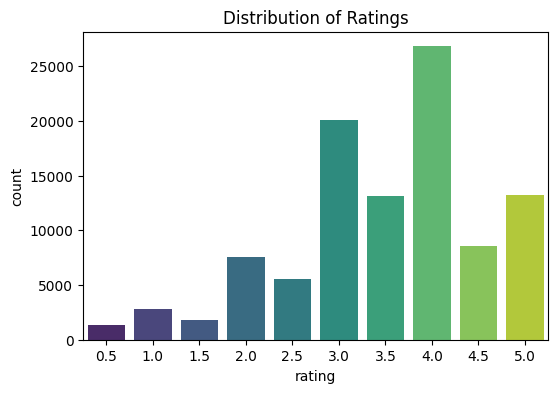

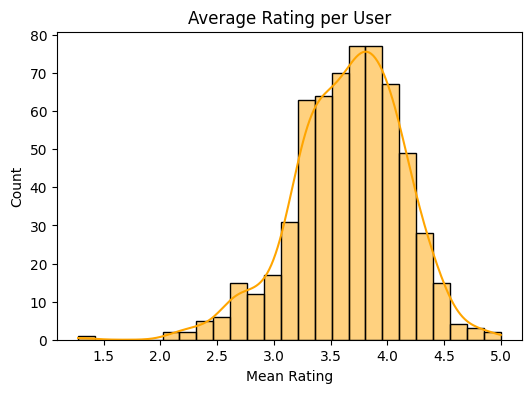


Shape of user-item matrix: (610, 9724)
User-Item matrix sample:
movieId    1    2    3    4    5
userId                          
1        4.0  0.0  4.0  0.0  0.0
2        0.0  0.0  0.0  0.0  0.0
3        0.0  0.0  0.0  0.0  0.0
4        0.0  0.0  0.0  0.0  0.0
5        4.0  0.0  0.0  0.0  0.0

[SVD Results]
RMSE: 0.8775, MAE: 0.6742
Computing the cosine similarity matrix...
Done computing similarity matrix.

[KNNBasic Results]
RMSE: 0.9806, MAE: 0.7552

Comparison of the two algorithms on test set:
  Algorithm      RMSE       MAE
0       SVD  0.877468  0.674175
1  KNNBasic  0.980566  0.755153


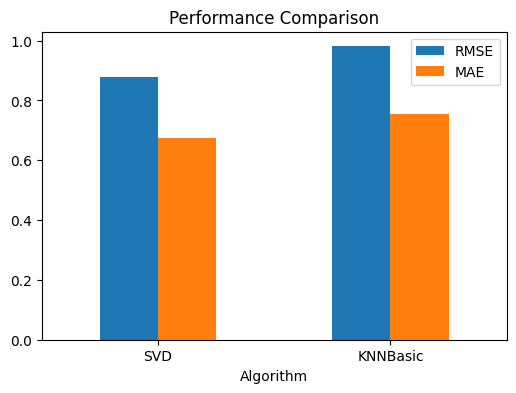

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load MovieLens 100k data
ratings = pd.read_csv(
    '/content/drive/MyDrive/BERT4Rec_Data/ml_100k_ratings.csv',
)

print("First 5 rows of the ratings data:")
print(ratings.head())

# Basic info
print("\nData info:")
print(ratings.info())

# Drop timestamp if you don't need it for your analysis
ratings.drop(columns='timestamp', inplace=True)

# Check for missing values
print("\nMissing values per column:")
print(ratings.isna().sum())

# EDA
print("\nNumber of unique users:", ratings['userId'].nunique())
print("Number of unique items:", ratings['movieId'].nunique())

# Distribution of ratings
plt.figure(figsize=(6,4))
sns.countplot(x='rating', data=ratings, palette='viridis')
plt.title("Distribution of Ratings")
plt.show()

# Average rating per user
user_mean_ratings = ratings.groupby('userId')['rating'].mean()
plt.figure(figsize=(6,4))
sns.histplot(user_mean_ratings, kde=True, color='orange')
plt.title("Average Rating per User")
plt.xlabel("Mean Rating")
plt.show()

# User-item matrix construction
user_item_matrix = ratings.pivot_table(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(0)

print("\nShape of user-item matrix:", user_item_matrix.shape)
print("User-Item matrix sample:")
print(user_item_matrix.iloc[:5, :5])

# Two collaborative filtering recommendation system algorithms
# 1) SVD (Matrix Factorization)
# 2) KNNBasic (User-based or Item-based)

from surprise import Reader, Dataset, SVD, KNNBasic
from surprise.model_selection import train_test_split
from surprise import accuracy

# Prepare data for Surprise
# Surprise expects a 'userId', 'movieId', 'rating' format
reader = Reader(rating_scale=(1, 5))  # Ratings go from 1 to 5
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# Split into train and test sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

svd_model = SVD(n_factors=50, random_state=42)
svd_model.fit(trainset)
svd_predictions = svd_model.test(testset)

# Evaluate on RMSE and MAE
svd_rmse = accuracy.rmse(svd_predictions, verbose=False)
svd_mae = accuracy.mae(svd_predictions, verbose=False)
print("\n[SVD Results]")
print(f"RMSE: {svd_rmse:.4f}, MAE: {svd_mae:.4f}")

# Simple user-based CF approach
sim_options = {
    'name': 'cosine',      # similarity measure
    'user_based': True     # set to False for item-based
}
knn_model = KNNBasic(sim_options=sim_options)
knn_model.fit(trainset)
knn_predictions = knn_model.test(testset)

# Evaluate on RMSE and MAE
knn_rmse = accuracy.rmse(knn_predictions, verbose=False)
knn_mae = accuracy.mae(knn_predictions, verbose=False)
print("\n[KNNBasic Results]")
print(f"RMSE: {knn_rmse:.4f}, MAE: {knn_mae:.4f}")

print("\nComparison of the two algorithms on test set:")
results_df = pd.DataFrame({
    'Algorithm': ['SVD', 'KNNBasic'],
    'RMSE': [svd_rmse, knn_rmse],
    'MAE': [svd_mae, knn_mae]
})
print(results_df)

results_df.plot(
    x='Algorithm',
    y=['RMSE', 'MAE'],
    kind='bar',
    figsize=(6,4),
    title='Performance Comparison',
    rot=0
)
plt.show()

# CITATIONS / RESOURCES:
# 1. https://grouplens.org/datasets/movielens/100k/
# 2. Surprise library documentation: https://surprise.readthedocs.io/
# 3. Herlocker, J., Konstan, J., Terveen, L., & Riedl, J. (2004).
#    Evaluating collaborative filtering recommender systems. ACM TOIS.
